#                                         Lending Club Loan Data

## Import Data

In [129]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In [130]:
SAMPLE = True

In [131]:
loans = pd.read_csv('../project_1/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True) #Load data into pandas

if SAMPLE:
    loans = loans.sample(frac=0.01)

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [132]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22607 entries, 1931676 to 1054516
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 26.2+ MB


In [133]:
pd.options.display.float_format = '{:,.2f}'.format 

In [134]:
loans.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1931676,1193493,nan,"5,600.00","5,600.00","5,575.00",60 months,8.90,115.98,A,A5,Sage software,10+ years,MORTGAGE,"81,996.00",Verified,Mar-2012,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1193493,Borrower added on 03/16/12 > Chev truck trailer<br>,car,CHEVY AND TRAILER,852xx,AZ,21.60,0.00,Feb-1987,750.00,754.00,0.00,81.00,nan,10.00,0.00,"40,230.00",76.80,36.00,f,0.00,0.00,"6,958.44","6,927.37","5,600.00","1,358.44",0.00,0.00,0.00,Apr-2017,115.62,NaN,Apr-2018,694.00,690.00,0.00,nan,1.00,Individual,nan,nan,NaN,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,nan,"3,170.00",78.00,0.00,0.00,nan,nan,nan,nan,3.00,7.00,nan,7.00,81.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,50.00,0.00,0.00,nan,"52,164.00","14,400.00",nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
521579,126110988,nan,"15,000.00","15,000.00","14,975.00",36 months,6.72,461.24,A,A3,Mining Technician,1 year,MORTGAGE,"85,000.00",Source Verified,Jan-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=126110988,NaN,credit_card,Credit card refinancing,628xx,IL,11.17,0.00,May-2007,665.00,669.00,1.00,41.00,nan,8.00,0.00,"9,327.00",64.30,17.00,f,"9,522.03","9,506.16","6,451.76","6,441.01","5,477.97",973.79,0.00,0.00,0.00,Mar-2019,461.24,Apr-2019,Mar-2019,684.00,680.00,0.00,41.00,1.00,Individual,nan,nan,NaN,0.00,0.00,"75,132.00",1.00,2.00,2.00,2.00,3.00,"22,638.00",89.00,0.00,2.00,"2,080.00",80.00,"14,500.00",1.00,1

In [135]:
loans.shape

(22607, 151)

## Target Variable

The Target Variable in this loan data is "Loan_Status", which we focus more on either loan status is "Fully Paid" or Charged Off. Will check on value counts of "Loan_Status" variable.

In [136]:
loans['loan_status'].value_counts(dropna=False) 

Fully Paid                                             10746
Current                                                 8821
Charged Off                                             2675
Late (31-120 days)                                       210
In Grace Period                                           92
Late (16-30 days)                                         42
Does not meet the credit policy. Status:Fully Paid        11
Does not meet the credit policy. Status:Charged Off       10
Name: loan_status, dtype: int64

Will exclude the loans which status are in Current,Late (31-120 days),In Grace Period,Late (16-30 days),Does not meet the credit policy. Status:Fully Paid,Does not meet the credit policy. Status:Charged Off,Default and missing status

In [137]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])] #Ignore other loan_status

In [138]:
loans['loan_status']

1931676     Fully Paid
971972      Fully Paid
528334      Fully Paid
340581     Charged Off
1998526    Charged Off
1723280    Charged Off
1351163     Fully Paid
978543      Fully Paid
664518      Fully Paid
1658098     Fully Paid
2092189     Fully Paid
1309272     Fully Paid
1615080     Fully Paid
175847      Fully Paid
1303539     Fully Paid
1850432     Fully Paid
888859      Fully Paid
400605      Fully Paid
327024      Fully Paid
1112427     Fully Paid
1252398     Fully Paid
1130804    Charged Off
140690      Fully Paid
475047     Charged Off
1763332     Fully Paid
1342248     Fully Paid
73469       Fully Paid
1091519     Fully Paid
1931267     Fully Paid
407874      Fully Paid
96504       Fully Paid
1052589    Charged Off
951583      Fully Paid
1086638    Charged Off
188599      Fully Paid
897773      Fully Paid
456129      Fully Paid
78057      Charged Off
598718      Fully Paid
1777977     Fully Paid
1076056     Fully Paid
733917      Fully Paid
1823895     Fully Paid
182185     

Loan_Status counts as percentages

In [139]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64

80% are Fully Paid, 20% are Charged Off 

## Data Preparation

Drop columns with >30% data missing

Calculate the missing data percentages of each feature

In [140]:
missing_data = loans.isnull().mean().sort_values(ascending=False) #calculate % of missing data

In [141]:
drop_list = sorted(list(missing_data[missing_data > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [142]:
len(drop_list) #Missing data >30% columns

58

In [143]:
loans.drop(labels=drop_list, axis=1, inplace=True) # Drop columns

### Keep variables needed for Investors

In [144]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [145]:
len(keep_list)

31

In [146]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list) #List remaining features not needed for investors

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [147]:
len(drop_list)

62

In [148]:
loans.drop(labels=drop_list, axis=1, inplace=True) #Drop Features

In [149]:
loans.shape #Remaining Columns

(13421, 31)

## Exploratory Data Analysis

Check dtypes of columns 

In [150]:
loans.dtypes

id                       object
loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
zip_code                 object
addr_state               object
dti                     float64
earliest_cr_line         object
fico_range_low          float64
fico_range_high         float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
dtype: o

In [151]:
loans.select_dtypes(include=np.object).columns.tolist() # Object data type columns

['id',
 'term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

In [152]:
loans.select_dtypes(include=np.float).columns.tolist() # Float data type columns

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

### Analyzing Categorical data

id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status',
'issue_d', 'loan_status', 'purpose', 'title',  'zip_code', 'addr_state',  'earliest_cr_line', 'initial_list_status',
'application_type'

#### Id

In [153]:
loans['id'].describe() #Usually ID's are unique and independent keys

count       13421
unique      13421
top       1179637
freq            1
Name: id, dtype: int64

In [154]:
loans.drop('id', axis=1, inplace=True) #drop id

#### Term

In [155]:
loans['term'].value_counts(dropna=False)

 36 months    10141
 60 months     3280
Name: term, dtype: int64

In [156]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0])) #convert them into numericals

In [157]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36   0.15
60   0.34
Name: loan_status, dtype: float64

Charge off rates for 60 months are 2x higher than for 36 months term

#### Grade and Sub Grade

In [158]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [159]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


Both are same, drop one column either grade or sub grade, I am dropping grade column here

In [160]:
loans.drop('grade', axis=1, inplace=True) #Drop grade

In [161]:
def plot_var(col_name, full_name, continuous):  # plot function
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


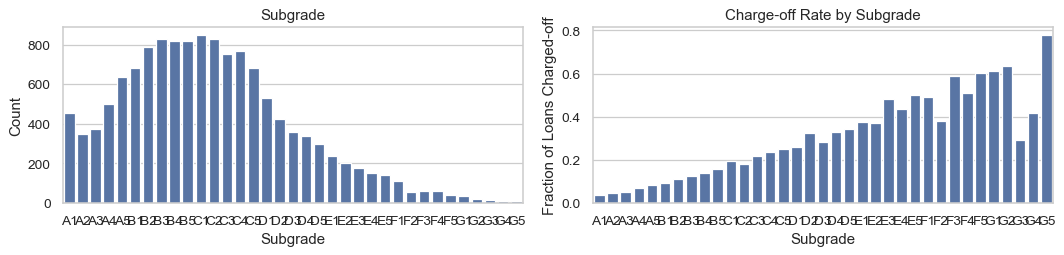

In [162]:
plot_var('sub_grade', 'Subgrade', continuous=False)

From the above plot, we can find that charge off rates increases with sub grade

#### Employment title

In [163]:
loans['emp_title'].describe()

count       12559
unique       7859
top       Teacher
freq          219
Name: emp_title, dtype: object

In [164]:
loans.drop(labels='emp_title', axis=1, inplace=True) #too many unique values

#### Employment length

In [165]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        906
10+ years    4514
2 years      1217
3 years      1032
4 years       763
5 years       812
6 years       616
7 years       602
8 years       604
9 years       531
< 1 year     1037
NaN           787
Name: emp_length, dtype: int64

Remove years from emp_length variables and convert them into float

In [166]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True) #Replace 0 years with 1 year

In [167]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True) # Replace 10+years with 10 years

In [168]:
def emp_length_to_int(s):
    if pd.isnull(s): 
        return s
    else:
        return np.int8(s.split()[0])

In [169]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [170]:
loans['emp_length'] = loans['emp_length'].fillna(loans.emp_length.median()) # fill missing values by taking median imputation

In [171]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.00     1037
1.00      906
2.00     1217
3.00     1032
4.00      763
5.00      812
6.00     1403
7.00      602
8.00      604
9.00      531
10.00    4514
Name: emp_length, dtype: int64

In [172]:
loans.groupby('emp_length')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

emp_length
0.00    0.22
1.00    0.22
2.00    0.19
3.00    0.19
4.00    0.18
5.00    0.21
6.00    0.23
7.00    0.20
8.00    0.19
9.00    0.21
10.00   0.19
Name: loan_status, dtype: float64

Charge off rates are decreasing when employment length increases

#### Home Ownership

In [173]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    6691
RENT        5255
OWN         1471
ANY            2
OTHER          2
Name: home_ownership, dtype: int64

We can merge None, Any as Other

In [174]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [175]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    6691
RENT        5255
OWN         1471
OTHER          4
Name: home_ownership, dtype: int64

In [176]:
home_ownership_xt = pd.crosstab(loans['home_ownership'], loans['loan_status'])
home_ownership_xt #Cross table

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,1170,5521
OTHER,1,3
OWN,305,1166
RENT,1199,4056


Text(0, 0.5, 'Loan Status')

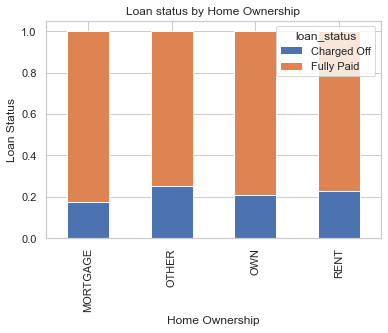

In [177]:
home_ownership_xt_pct = home_ownership_xt.div(home_ownership_xt.sum(1).astype(float), axis=0)

home_ownership_xt_pct.plot(kind='bar', 
                   stacked=True, 
                   title='Loan status by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Loan Status')

Charge off rates are higher for Rent and Own home owner ship with 23% and 21% respectively

In [178]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE   0.17
OTHER      0.25
OWN        0.21
RENT       0.23
Name: loan_status, dtype: float64

#### Verification Status

In [179]:
loans.groupby('verification_status')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

verification_status
Not Verified      0.14
Source Verified   0.21
Verified          0.25
Name: loan_status, dtype: float64

Charge off rates are higher for Verified compared to other two types

#### Purpose

In [180]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    6691
RENT        5255
OWN         1471
OTHER          4
Name: home_ownership, dtype: int64

In [181]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

purpose
car                  0.16
credit_card          0.17
debt_consolidation   0.21
educational          0.50
home_improvement     0.16
house                0.17
major_purchase       0.19
medical              0.20
moving               0.14
other                0.22
renewable_energy     0.33
small_business       0.33
vacation             0.16
wedding              0.15
Name: loan_status, dtype: float64

#### Title

In [182]:
loans['title'].describe()

count                  13252
unique                  1166
top       Debt consolidation
freq                    6525
Name: title, dtype: object

In [183]:
loans['title'].value_counts().head

<bound method NDFrame.head of Debt consolidation                                                            6525
Credit card refinancing                                                       2548
Home improvement                                                               755
Other                                                                          681
Major purchase                                                                 238
Debt Consolidation                                                             146
Medical expenses                                                               143
Car financing                                                                  116
Business                                                                       116
Vacation                                                                        89
Moving and relocation                                                           82
Consolidation                                            

Purpose and Title are quite similar so we can drop either one column

In [184]:
loans.drop('title', axis=1, inplace=True)

#### Zip code and Address state 

In [185]:
loans['zip_code'].describe()

count     13421
unique      806
top       750xx
freq        148
Name: zip_code, dtype: object

In [186]:
loans['addr_state'].sample(5)

983838     PA
1984334    NJ
284709     SC
60951      NJ
1015394    NC
Name: addr_state, dtype: object

In [187]:
loans['addr_state'].nunique()

50

Zip code and address are quite similar which tells about address of applicant, so we will drop one column with more unique values

In [188]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
ME   0.06
UT   0.11
DC   0.12
OR   0.12
MT   0.12
SC   0.13
KS   0.14
ND   0.14
NH   0.15
AR   0.15
CO   0.15
WV   0.15
WA   0.16
OH   0.17
RI   0.18
AZ   0.18
IN   0.18
AK   0.18
TX   0.18
NJ   0.19
AL   0.19
WI   0.19
MI   0.19
GA   0.20
MA   0.20
CA   0.20
NC   0.20
IL   0.20
NM   0.20
CT   0.21
PA   0.21
MN   0.21
ID   0.21
FL   0.21
MO   0.22
DE   0.22
KY   0.23
NY   0.23
MD   0.23
NV   0.24
OK   0.24
TN   0.24
HI   0.25
NE   0.26
VA   0.26
SD   0.26
VT   0.28
LA   0.29
WY   0.29
MS   0.34
Name: loan_status, dtype: float64

MS state having highest charge off rates with 26%

In [189]:
loans.drop(labels='zip_code', axis=1, inplace=True)

#### Initial list status

In [190]:
loans['initial_list_status'].describe()

count     13421
unique        2
top           w
freq       7837
Name: initial_list_status, dtype: object

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


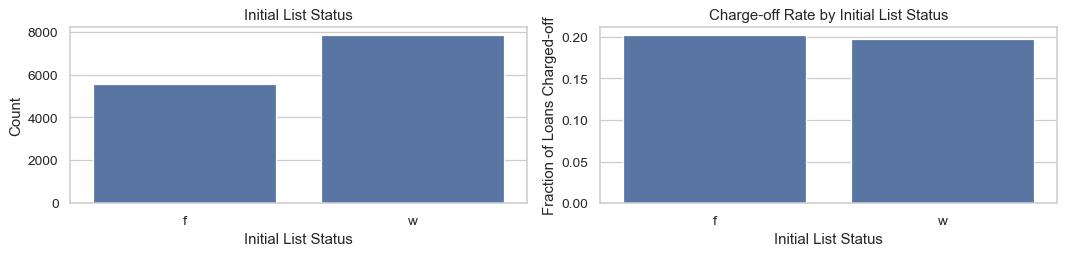

In [191]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

Charge off rates for "w" and "f" status are similar with 20%

#### Application type

In [192]:
loans['application_type'].value_counts(normalize=True)

Individual   0.98
Joint App    0.02
Name: application_type, dtype: float64

In [193]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual   0.20
Joint App    0.21
Name: loan_status, dtype: float64

2% Loan applicants are Joint application types which are having 25% of charge off rates 

### Analyzing Numerical Data

#### Loan amount

In [194]:
loans['loan_amnt'].describe()

count   13,421.00
mean    14,442.97
std      8,715.51
min      1,000.00
25%      7,950.00
50%     12,000.00
75%     20,000.00
max     40,000.00
Name: loan_amnt, dtype: float64

In [195]:
loans['loan_amnt'] = loans['loan_amnt'].apply(lambda x: np.log10(x+1)) #applying log10 to calculate numerical value

In [196]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",4.12,0.29,3.00,3.98,4.18,4.34,4.60
Fully Paid,"10,746.00",4.06,0.30,3.00,3.87,4.08,4.30,4.60


#### Interest Rate

In [197]:
loans['int_rate'].describe()

count   13,421.00
mean        13.22
std          4.76
min          5.31
25%          9.75
50%         12.74
75%         15.81
max         30.99
Name: int_rate, dtype: float64

In [198]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",15.90,5.03,5.32,12.39,15.31,18.99,30.99
Fully Paid,"10,746.00",12.56,4.44,5.31,9.17,12.12,15.04,30.99


In [199]:
loans.groupby('purpose')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
purpose,,,,,,,,
car,159.00,11.89,4.37,5.32,8.21,11.49,14.46,28.72
credit_card,"2,981.00",11.74,4.19,5.31,8.24,11.44,13.99,30.84
debt_consolidation,"7,722.00",13.65,4.74,5.31,10.42,13.11,16.29,30.99
educational,2.00,13.05,0.79,12.49,12.77,13.05,13.33,13.61
home_improvement,867.00,12.64,4.82,5.32,8.90,12.39,15.59,30.99
house,70.00,14.90,5.95,5.32,9.86,14.32,18.25,28.69
major_purchase,302.00,12.83,4.90,5.31,8.39,12.73,15.61,30.49
medical,172.00,13.53,4.40,5.31,10.75,13.33,16.29,28.69
moving,95.00,15.54,5.61,5.32,12.02,15.31,18.49,30.94


In [200]:
loans.groupby('sub_grade')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
sub_grade,,,,,,,,
A1,457.00,5.54,0.34,5.31,5.32,5.32,6.03,7.12
A2,351.00,6.55,0.33,5.79,6.24,6.49,6.62,7.68
A3,376.00,7.12,0.34,6.17,6.89,6.99,7.24,8.00
A4,500.00,7.51,0.33,6.54,7.26,7.46,7.84,8.60
A5,634.00,8.21,0.41,6.91,7.89,7.98,8.46,9.63
B1,684.00,8.88,0.71,8.18,8.24,8.49,9.44,11.14
B2,790.00,9.92,0.74,9.16,9.17,9.93,10.56,11.48
B3,826.00,10.75,0.85,9.62,9.99,10.49,11.55,12.12
B4,819.00,11.46,0.80,6.00,10.99,10.99,11.67,13.11


#### Installment

In [201]:
loans['installment'].describe()

count   13,421.00
mean       438.46
std        261.70
min         21.62
25%        246.99
50%        375.49
75%        583.51
max      1,715.42
Name: installment, dtype: float64

In [202]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",479.74,270.23,21.62,283.25,421.66,640.08,"1,715.42"
Fully Paid,"10,746.00",428.18,258.52,30.12,239.01,364.73,567.01,"1,691.28"


#### Annual Income

In [203]:
loans['annual_inc'].describe()

count      13,421.00
mean       76,495.50
std        74,084.41
min             0.00
25%        46,000.00
50%        65,000.00
75%        90,000.00
max     6,000,000.00
Name: annual_inc, dtype: float64

In [204]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [205]:
loans.drop('annual_inc', axis=1, inplace=True)

In [206]:
loans['log_annual_inc'].describe()

count   13,421.00
mean         4.81
std          0.24
min          0.00
25%          4.66
50%          4.81
75%          4.95
max          6.78
Name: log_annual_inc, dtype: float64

In [207]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",4.79,0.24,3.98,4.64,4.78,4.93,6.04
Fully Paid,"10,746.00",4.82,0.24,0.00,4.67,4.81,4.96,6.78


#### Debt to Income ratio

In [208]:
loans['dti'].describe()

count   13,419.00
mean        18.31
std          9.83
min         -1.00
25%         11.91
50%         17.66
75%         24.17
max        502.41
Name: dti, dtype: float64

In [209]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",20.11,9.05,0.46,13.54,19.80,26.30,92.39
Fully Paid,"10,744.00",17.87,9.96,-1.00,11.55,17.13,23.56,502.41


#### FICO range

In [210]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,"13,421.00","13,421.00"
mean,696.43,700.43
std,31.97,31.97
min,660.00,664.00
25%,670.00,674.00
50%,690.00,694.00
75%,710.00,714.00
max,845.00,850.00


In [211]:
loans[['fico_range_low','fico_range_high']].corr() #Calculating correlation

,fico_range_low,fico_range_high
fico_range_low,1.00,1.00
fico_range_high,1.00,1.00


In [212]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [213]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [214]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",689.93,25.20,662.00,672.00,682.00,702.00,842.00
Fully Paid,"10,746.00",700.55,33.11,662.00,677.00,692.00,717.00,847.50


#### Open credit lines and Total accounts

In [215]:
loans[['open_acc','total_acc']].corr()

,open_acc,total_acc
open_acc,1.00,0.71
total_acc,0.71,1.00


In [216]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",11.95,5.55,2.00,8.00,11.00,15.00,53.00
Fully Paid,"10,746.00",11.51,5.44,1.00,8.00,11.00,14.00,58.00


In [217]:
loans['acc_ratio'] = loans['open_acc'] / loans['total_acc']

In [218]:
loans.drop(['total_acc','open_acc'], axis=1, inplace=True)

#### Public records and Public records brankrupticies

In [219]:
loans[['pub_rec','pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.00,0.65
pub_rec_bankruptcies,0.65,1.00


In [220]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,675.00",0.26,0.65,0.00,0.00,0.00,0.00,11.00
Fully Paid,"10,746.00",0.21,0.60,0.00,0.00,0.00,0.00,11.00


In [221]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.00    11720
1.00     1602
2.00       71
3.00       15
4.00        3
5.00        1
8.00        1
Name: pub_rec_bankruptcies, dtype: int64

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


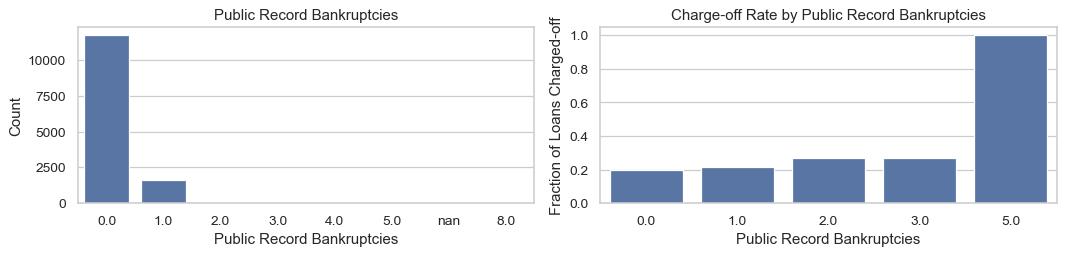

In [222]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

In [223]:
loans.drop('pub_rec', axis=1, inplace=True)

#### Revolving balance

In [224]:
loans['revol_bal'].describe()

count      13,421.00
mean       16,339.91
std        26,874.87
min             0.00
25%         5,907.00
50%        10,996.00
75%        19,520.00
max     1,746,716.00
Name: revol_bal, dtype: float64

In [225]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [226]:
loans.drop('revol_bal', axis=1, inplace=True)

#### Revolving util

In [227]:
loans['revol_util'].describe()

count   13,414.00
mean        51.53
std         24.67
min          0.00
25%         33.30
50%         52.00
75%         70.00
max        139.70
Name: revol_util, dtype: float64

In [228]:
loans[['revol_util','fico_score']].corr()

,revol_util,fico_score
revol_util,1.00,-0.45
fico_score,-0.45,1.00


In [229]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,673.00",54.55,24.01,0.00,37.20,55.50,72.20,139.70
Fully Paid,"10,741.00",50.78,24.78,0.00,32.40,51.10,69.40,122.40


#### Mortgage account

In [230]:
loans['mort_acc'].describe()

count   12,935.00
mean         1.70
std          2.02
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         16.00
Name: mort_acc, dtype: float64

In [231]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,604.00",1.44,1.89,0.00,0.00,1.00,2.00,15.00
Fully Paid,"10,331.00",1.76,2.04,0.00,0.00,1.00,3.00,16.00


### Date type columns

In [232]:
loans['issue_d'].sample(5)

1332097    Feb-2014
283391     May-2015
1278308    May-2014
1204682    Sep-2014
246424     Jun-2015
Name: issue_d, dtype: object

In [233]:
loans['earliest_cr_line'].sample(5)

638215     Oct-2010
1177162    Apr-2008
1314478    Oct-2007
625063     May-2005
1272269    Nov-1998
Name: earliest_cr_line, dtype: object

In [234]:
loans['earliest_cr_line'].isnull().any()

False

In [235]:
loans['issue_d'].isnull().any()

False

In [236]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

Text(0.5, 1.0, 'Loans Funded per Year')

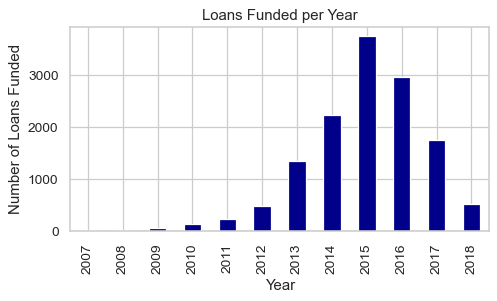

In [237]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

In [238]:
loans['earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line'])

Calculate number of days between issue date and earliest credit lines, so that we know the days of applicant with the bank

In [239]:
loans['days_from_issue_to_earliest_cr'] = (loans['issue_d'] - loans['earliest_cr_line']).apply(lambda x: x.days)

In [240]:
loans['days_from_issue_to_earliest_cr'].sample(5)

1896850    2680
1823910    4870
961393     3774
664530     3773
1305713    4442
Name: days_from_issue_to_earliest_cr, dtype: int64

In [241]:
loans['target'] = (loans['loan_status'] == 'Charged Off').astype(int)
loans['target'].describe()

count   13,421.00
mean         0.20
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: target, dtype: float64

In [242]:
_df = loans.groupby('days_from_issue_to_earliest_cr')['target'].mean().reset_index()

<AxesSubplot:xlabel='days_from_issue_to_earliest_cr', ylabel='target'>

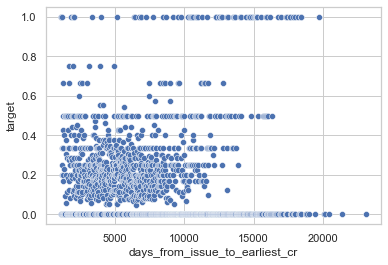

In [243]:
sns.scatterplot(x='days_from_issue_to_earliest_cr', y='target', data=_df)

In [244]:
_df.corr()

,days_from_issue_to_earliest_cr,target
days_from_issue_to_earliest_cr,1.00,-0.05
target,-0.05,1.00


In [245]:
loans.drop(['target','earliest_cr_line'],axis=1,inplace=True)

#### More Pre preprocessing

Convert charge off in loan status as 0/1 indicator

In [246]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [247]:

missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [248]:

print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

mort_acc               0.04
pub_rec_bankruptcies   0.00
revol_util             0.00
dti                    0.00
dtype: float64


In [249]:

print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'revol_util', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'fico_score', 'acc_ratio', 'log_revol_bal',
       'days_from_issue_to_earliest_cr', 'charged_off'],
      dtype='object')


Create dummy variables for categorical data

In [250]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status','application_type'], drop_first=True)



In [251]:
loans.shape

(13421, 119)

In [252]:
import pyarrow.feather as feather
feather.write_feather(loans,'./loans_modelling_data')

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\pyarrow\feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):
